## Medical Transcript Exploration Using Comprehend Medical

In [1]:
from botocore.vendored import requests
import json
import boto3
import pandas as pd
import pypandoc
import time
from IPython.display import display, Markdown, HTML, Audio

In [2]:
cm = boto3.client(service_name='comprehendmedical')
s3 = boto3.client('s3')
textract = boto3.client('textract')
bucketName = 'demo-ccf'

### The Image / Scan

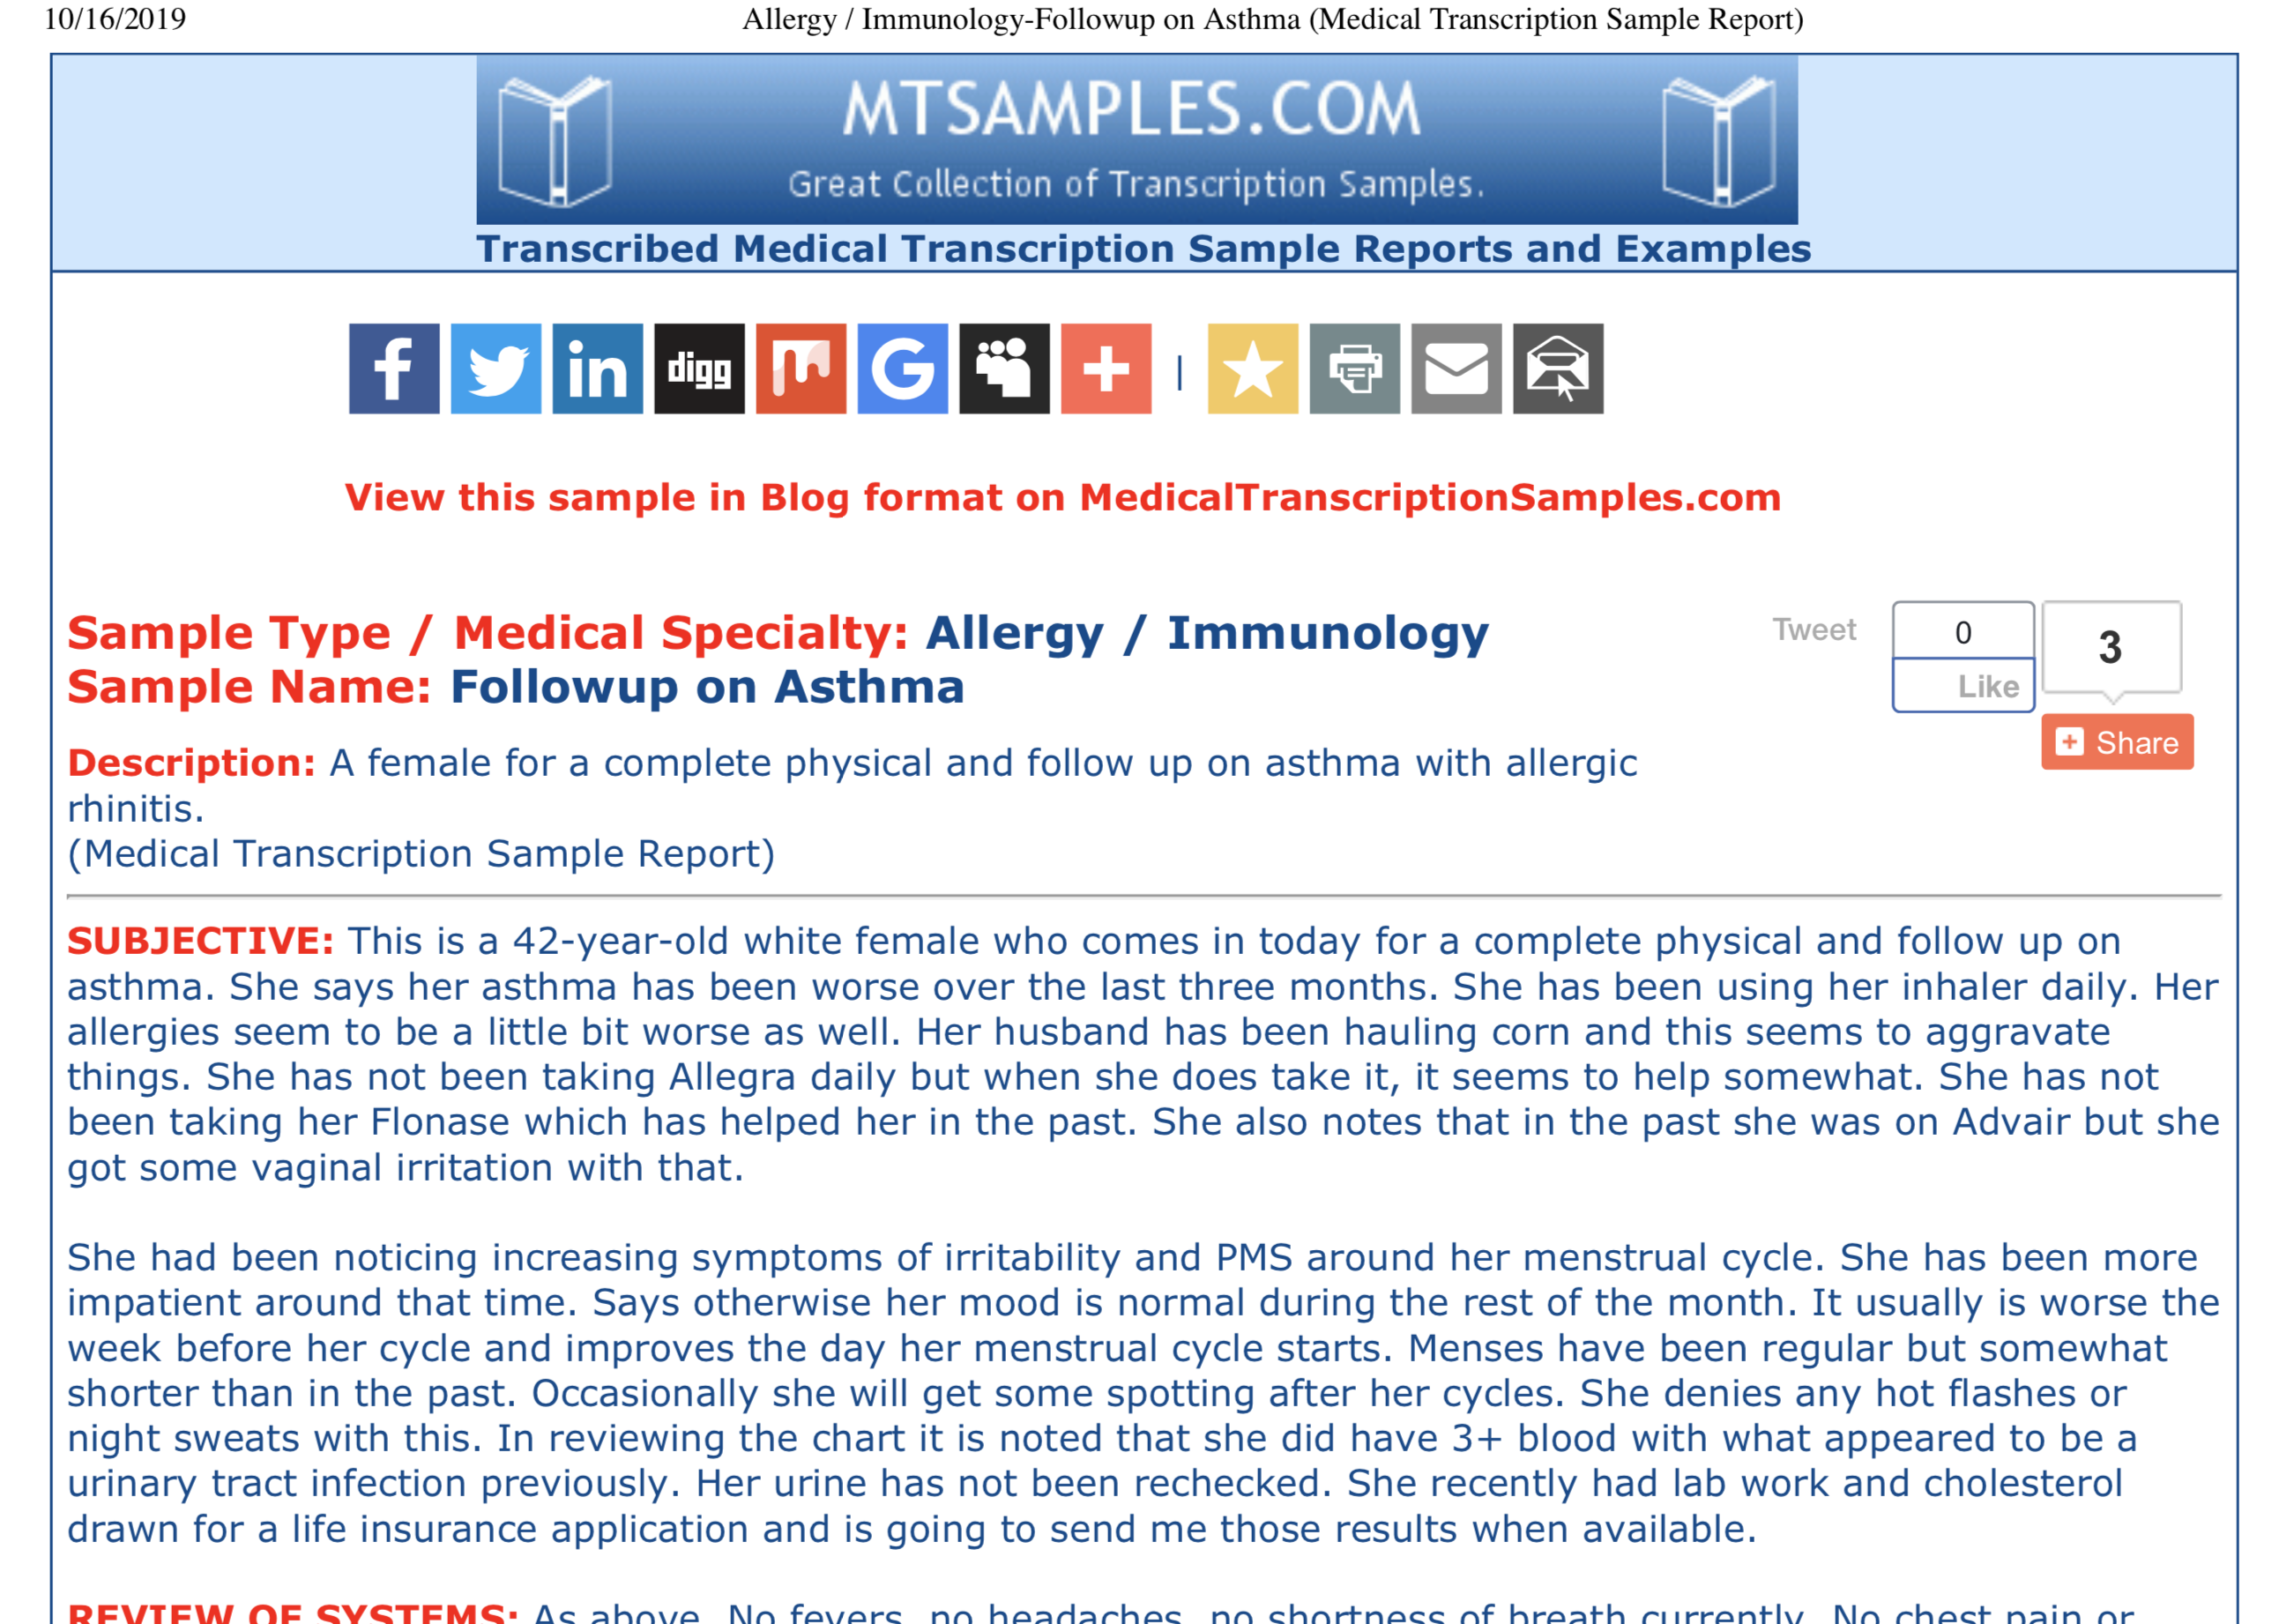

In [3]:
from IPython.display import Image
Image(filename='notes.png')

### Copy the image to a location in S3

In [5]:
import boto3
s3 = boto3.resource('s3')
s3.meta.client.upload_file('./notes.png', bucketName, 'notes.png')

### Send the image data to Textract

In [6]:
def getTextractData(bucketName, documentKey):
    print('Loading getTextractData')
    # Call Amazon Textract
    response = textract.detect_document_text(
        Document={
            'S3Object': {
                'Bucket': bucketName,
                'Name': documentKey
            }
        })
        
    detectedText = ''

    for item in response['Blocks']:
        if item['BlockType'] == 'LINE':
            detectedText += item['Text'] + '\n'
            
    return detectedText, response

documentKey = "notes.png"

mtsamples_text, original_response = getTextractData(bucketName, documentKey)
mtsamples_text = mtsamples_text.replace("\n", " ")
mtsamples_text

Loading getTextractData


'10/16/2019 Allergy y/Immunology-Followup on Asthma (Medical Transcription Sample Report) MTSAMPLES.CON Great Collection of Transcription Samples. Transcribed Medical Transcription Sample Reports and Examples f in digg G View this sample in Blog format on MedicalTranscriptionsamples.com Sample Type / Medical Specialty: Allergy / Immunology Tweet 0 3 Sample Name: Followup on Asthma Like Description: A female for a complete physical and follow up on asthma with allergic + Share rhinitis. (Medica Transcription Sample Report) SUBJECTIVE: This is a 42-year-old white female who comes in today for a complete physical and follow up on asthma. She says her asthma has been worse over the last three months. She has been using her inhaler daily. Her allergies seem to be a little bit worse as well. Her husband has been hauling corn and this seems to aggravate things. She has not been taking Allegra daily but when she does take it, it seems to help somewhat. She has not been taking her Flonase which

In [ ]:
import json
print(json.dumps(original_response, indent=2))

### Invoke Comprehend Medical and Get Results

In [ ]:
# Creating empty lists for a dataframe
df_d = []  # Diagnosis
df_s = []  # Symptoms
df_m = []  # Medications

# Call the detect_entities API to extract the entities
testresult = cm.detect_entities(Text = mtsamples_text)

testresult

In [ ]:
# Defining variables for creating Wordclouds
text = ''
symptoms = ''
medication = ''
diagnosis = ''

# Create a list of entities
testentities = testresult['Entities']

# Creating a loop to iterate through the individual entities
for row in testentities:

    # Redacting PHI (Personal Health Information) from the extracted entites
    if row['Category'] != "PERSONAL_IDENTIFIABLE_INFORMATION":
        text += row['Text'] + ' '

        if len(row['Traits']) == 1 and row['Traits'][0]['Name'] == "SYMPTOM":
            symptoms += row['Text'] + ' '
            df_s.append(row['Text'])

        if row['Category'] == "MEDICATION":
            medication += row['Text'] + ' '
            df_m.append(row['Text'])

        if len(row['Traits']) == 1 and row['Traits'][0]['Name'] == "DIAGNOSIS":
            diagnosis += row['Text'] + ' '
            df_d.append(row['Text'])

### Visualizing the results

In [ ]:
# Creating visualizations

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

def medical_resume_wordcloud(text):
    # take relative word frequencies into account, lower max_font_size
    wordcloud = WordCloud(width = 600, height = 300, background_color = 'black', max_words = len(text),
                          max_font_size = 30, relative_scaling = .5, colormap = 'Spectral').generate(text)
    plt.figure(figsize = (20, 10))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()


In [ ]:
medical_resume_wordcloud(text)

In [ ]:
medical_resume_wordcloud(diagnosis)


In [ ]:
medical_resume_wordcloud(medication)